In [1]:
from imp import reload
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm as umm
import mallows_hamming as mh
import mallows_kendall as mk
from scipy.spatial.distance import *

In [4]:
# instance synthetic, the best sol is
n = 20
flow = np.random.random((n,n))
for i in range(n):
    for j in range(n):
        if i==j: flow[i,i]=0
        else: flow[i,j] += 1/(abs(i-j))
for i in range(n):
    for j in range(n):
        print(round(flow[i,j],4), " ", end="")
#         print(i-j if i-j>=0 else 10*n, " ", end="") #distance between locations
    print()

0.0  1.0483  1.0025  1.3112  1.0974  0.794  0.4253  0.9362  0.4502  0.2938  1.0384  0.1279  0.8711  0.126  0.8086  0.9765  0.771  1.0012  0.6244  0.6794  
1.7625  0.0  1.7387  1.0255  0.9617  0.7439  0.5189  0.4928  1.0712  0.1494  0.9092  0.6652  1.046  0.8588  0.5605  0.6204  0.8169  0.6441  0.2954  0.5367  
1.0028  1.2914  0.0  1.8099  0.5016  0.7811  0.921  0.9914  0.9653  0.269  1.0946  0.4592  0.173  0.6248  0.6258  0.6549  0.7853  0.7583  0.1017  0.862  
1.1876  1.0581  1.1311  0.0  1.5917  0.8378  1.0431  0.3257  0.3549  1.048  0.4311  0.9142  1.0915  0.7677  0.5079  0.3377  0.4226  0.2944  0.5857  0.3005  
1.0636  0.8202  0.8403  1.797  0.0  1.5581  1.4309  1.2097  1.0925  1.0594  0.548  0.2577  0.6185  0.9815  0.3301  0.1616  0.678  0.1024  0.7498  0.5065  
0.4869  0.8315  0.8964  1.1058  1.0224  0.0  1.2736  0.8259  1.2941  0.5033  0.6556  0.5647  0.6051  0.6911  0.8475  0.5272  1.0144  0.1097  0.6064  0.9442  
0.8585  0.4492  1.0088  0.806  1.383  1.2395  0.0  1.1693  0.812

In [38]:
reload(mk)
n = 20

mk.find_proba_mode(35, 0.00000002, tol=1e-20)

trace find proba 0 1.9899220809475684e-08
trace find proba 20 3.9113546067758913e-13
trace find proba 40 5.1030426349621383e-20


0.4116517369489401

In [227]:
reload(mk)
reload(mh)
reload(umm)
n = 10
dfh = pd.DataFrame()

dist_name = 'hamming'
mm = mk if dist_name=='kendall' else mh
dist_unif = mm.dist_at_uniform(n)
expected_dists = umm.get_expected_distance_at_iteration_t(dist_at_uniform=dist_unif,budget=100,scalfun='linear')
phi_sampling = np.array([mm.find_phi(n, i, i + 1) for i in expected_dists])
prob_modes = np.array([ mm.prob(np.arange(n), np.arange(n), phi=phi) for phi in phi_sampling])
dfh['expected_dist'] = expected_dists
dfh['phi_sampling'] = phi_sampling
dfh['prob_modes'] = prob_modes
dfh['dist_name'] = dist_name
dfh['iter'] = np.arange(len(dfh))

dist_name = 'kendall'
dfk = pd.DataFrame()
mm = mk if dist_name=='kendall' else mh
dist_unif = mm.dist_at_uniform(n)
expected_dists = umm.get_expected_distance_at_iteration_t(dist_at_uniform=dist_unif,budget=100,scalfun='log')
phi_sampling = np.array([mm.find_phi(n, i, i + 1) for i in expected_dists])
prob_modes = np.array([ mm.prob(np.arange(n), np.arange(n), phi=phi) for phi in phi_sampling])
dfk['expected_dist'] = expected_dists
dfk['phi_sampling'] = phi_sampling
dfk['prob_modes'] = prob_modes
dfk['dist_name'] = dist_name
dfk['iter'] = np.arange(len(dfk))

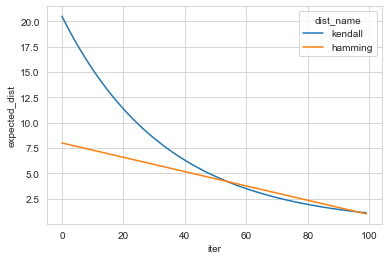

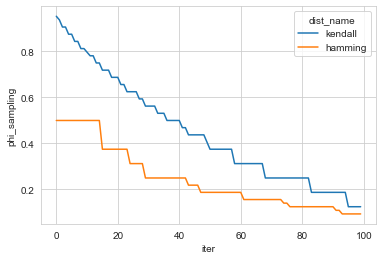

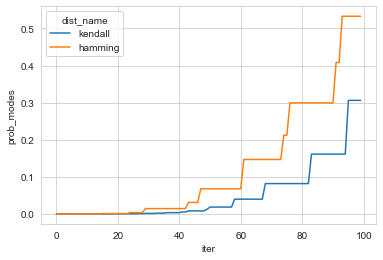

In [228]:
df = pd.concat([dfk,dfh])
col = 'expected_dist'
for col in ['expected_dist','phi_sampling','prob_modes']:
    sns.lineplot(data=df,x='iter', y=col, hue='dist_name')
    plt.show()

## Running UMM and CEGO over one instance

The next cell allows running CEGO and UMM over a chosen instance and with the selected parameters

In [2]:
reload(runner)
res = []
# budgetGA=10**3#
# instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.5"
# instance_name = "pfsp_csum/tai20_5_3.fsp"
instance_name="pfsp_csum/rec05.txt"
# instance_name="lop/RandB/N-p50-01"
# instance_name="lop/Spec/N-pal13"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug30.dat"
# instance_name="qap/nug12.dat"
# instance_name="qap/test.dat"
out_filename = "pickles/"+instance_name.replace("/", "_").replace(".txt", "")
seed=np.random.randint(100)
budget=20
m_ini=10
# estos son los parámetros que deberíamos probar
dist_name, scalfun_learning, scalfun_sampling, eval_ranks = 'kendall', ' exp', 'linear', False
# dist_name, scalfun_learning, scalfun_sampling, eval_ranks = 'hamming', 'exp', 'median', True

df = runner.run_once("UMM", instance_name, seed,budget = budget, m_ini = m_ini, 
                     out_filename = out_filename, eval_ranks=eval_ranks,init='random',
                     dist_name=dist_name,scalfun_learning=scalfun_learning, 
                     scalfun_sampling=scalfun_sampling)


Reading instance from pfsp_csum/rec05.txt
header: Reeves 20x5 type C instance



AssertionError: [19 28 21  3 29 17 26  1 15 20  0 11 16  5 23  9 18 12 14  4 22 13  6 25  7 24  2 10 27  8]

In [7]:
df = pd.read_csv(out_filename+ '.csv.xz')
color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    print("Mins overall: sample/median", df.Fitness.min(), df.feval_median.min())
    ax = plt.figure(figsize=(15,5))
    ax = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
    ax = sns.lineplot(x='Function evaluations',y='feval_median',data=df, palette=palette)
#     plt.savefig('img/'+instance_name.replace("/", "__").replace(".txt", "")+'order.eps')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/lop_Spec_N-pal13.csv.xz'

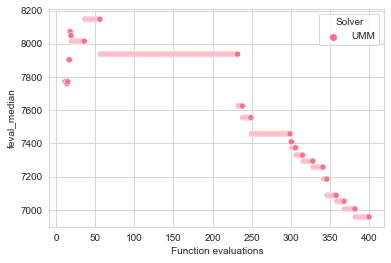

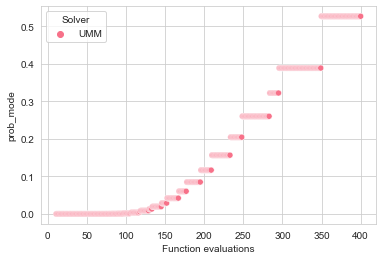

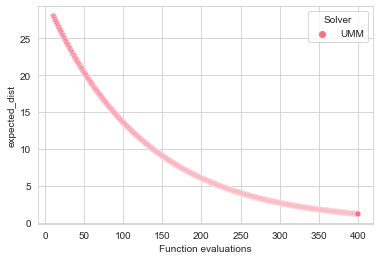

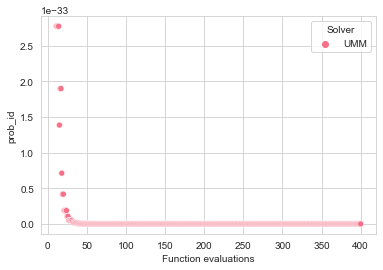

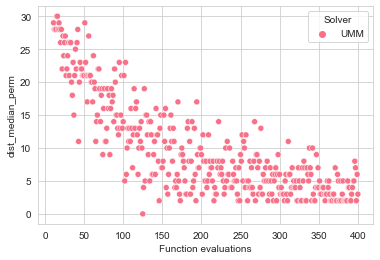

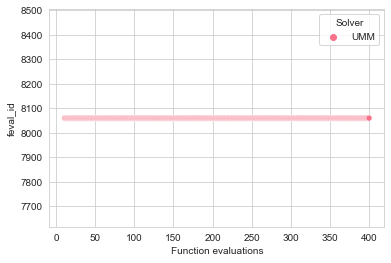

In [384]:
df
for y_variable in ['feval_median','prob_mode','expected_dist', 'prob_id', 'dist_median_perm','feval_id']:
  sns.scatterplot (x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
  plt.show()

- TFT pfsp_csum/tai20_5_8.fsp.txt"

    - budget=1000  -> 60k

    - budget=5000  -> 60k

    - best sols TFT https://www.researchgate.net/figure/Best-known-solutions-for-Taillards-benchmarks-with-respect-to-total-flowtime-criterion_tbl8_223094938
  
- makespan  pfsp_cmax/tai20_5_8.fsp.txt"

    - best sols makespan https://www.researchgate.net/publication/269820959_Handling_ties_in_heuristics_for_the_permutation_flow_shop_scheduling_problem/link/5e31680ba6fdccd9657373fd/download

In [489]:
#nug 12 el bego hamming va muy bien
path ='/Users/ekhine/Desktop/gits/BB_opt/results/m1000-er0-dist_kendall/qap/nug30.dat/cego.csv.xz'
dfgood = pd.read_csv(path)
perm_good = dfgood[dfgood.Fitness==dfgood.Fitness.min()].x.values
perm_good = np.array([np.array([int(i) for i in perm.split() if i !=' ']) for perm in perm_good])
perm_good
# best_sol = mh.uHungarian(perm_good, [1]*len(perm_good))


array([[10,  7, 26,  3, 19, 13, 22, 24, 29, 15, 27, 11, 17, 21, 18,  8, 12,  5, 16,  0,  9,  2, 20, 14, 25, 23,  6, 28,  1,  4]])

In [488]:
dfgood[dfgood.Fitness<600]

,Fitness,x,m_ini,seed,budget,budgetGA,eval_ranks,Distance,Function evaluations,run_time,Problem,instance,Solver


In [127]:

perm_good=perm_good[np.lexsort(np.rot90(perm_good))]


<AxesSubplot:>

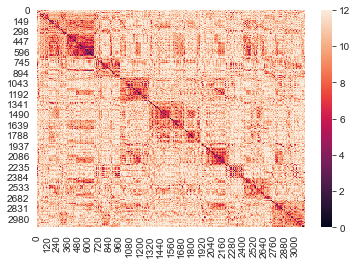

In [128]:

sq = squareform(pdist(perm_good,metric=mh.distance))
sns.heatmap(sq)

In [7]:
def read_alldata():
    lis = []
    for filename in glob("./results/**/*.csv.xz", recursive=True): 
        lis.append(pd.read_csv(filename))
    return pd.concat(lis, sort = True)
df = read_alldata()
df = df[~df.scalfun_sampling.isna()] # select just the new ones
# print(df.groupby([ 'Problem', 'Solver',
#        'budget', 'dist_name', 'eval_ranks', 'init',
#        'instance',
#         'scalfun_learning', 'scalfun_sampling', 'seed',
# ]).size())
df["Solver"] = df["Solver"].astype(str) +'_'+ df["dist_name"].astype(str) +'_'+ df["eval_ranks"].astype(str) +'_'+  df["budget"].astype(str)+'_'+  df["init"].astype(str)+'_'+  df["scalfun_learning"].astype(str)+'_'+  df["scalfun_sampling"].astype(str)


In [8]:
df[(df['Function evaluations']==1)].groupby(['Solver', 'instance'] ).size()#(df.seed==1) & 


Solver                             instance           
UMM_hamming_0_1000_random_exp_log  lop/IO/N-t59b11xx      80
                                   lop/IO/N-t59d11xx      80
                                   lop/RandB/N-p40-01     80
                                   lop/RandB/N-p40-02     80
                                   lop/RandB/N-p50-01     80
                                                          ..
UMM_kendall_0_500_random_exp_log   pfsp_cmax/rec31.txt    20
                                   qap/kra32.dat          20
                                   qap/nug12.dat          20
                                   qap/nug30.dat          20
                                   qap/tho30.dat          20
Length: 64, dtype: int64

In [9]:

for inst in df.instance.drop_duplicates():
  subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
  print("instance: ", inst)
  plt.figure(figsize=(18,5))
  palette = sns.color_palette("husl", subdf['Solver'].nunique())
  g = sns.lineplot(x='Function evaluations', y='Fitness', hue='Solver', style='dist_name', data=subdf, palette=palette)
#   g.set(xlim=(-1, 401))
  plt.tight_layout()
  filename = 'img/fitness_v2_' + subdf.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
  print("Saving to " + filename)
  plt.savefig(filename)
  plt.show()

instance:  pfsp_cmax/rec13.txt


In [ ]:
df.groupby([        'budget', 'dist_name'].


In [ ]:
df[df['Function evaluations'] == df.budget].groupby(['budget', 'dist_name']).run_time.mean()